Knowledge Distillation Tutorial
===============================

######################################################################

Enviroment Setup
----------

In [14]:
!nvidia-smi

Mon Dec  2 15:53:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   41C    P2             N/A /  115W |    3247MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import shutil
from tabulate import tabulate
import urllib.request
import tarfile


In [11]:
# Print the current working directory
print(f"The notebook is located in: {os.getcwd()}")

# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): # Should return True 
    print(f"Using GPU: {torch.cuda.get_device_name(0)}") # Should show your GPU name
else:
    print("Using CPU")

The notebook is located in: d:\Arcade_Pj\AA\Knowledge_Distillation_Testing
Using CPU


MVTec Hakan version (100 classes)
------------
split **4096** samples as **2903 (train)**, **726 (validation)**, and **467 (test)**.


In [ ]:
# Define the dataset URL and paths
url = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz"
dataset_tar = "mvtec_anomaly_detection.tar.xz"
dataset_path = "./data/mvtec_dataset"

# Download the dataset if it doesn't exist
if not os.path.exists(dataset_tar):
    print("Downloading MVTec dataset...")
    urllib.request.urlretrieve(url, dataset_tar)
    print(f"Downloaded to {dataset_tar}.")

# Extract the dataset if it's not already extracted
if not os.path.exists(dataset_path):
    print("Extracting MVTec dataset...")
    with tarfile.open(dataset_tar, "r:xz") as tar:
        tar.extractall(path=dataset_path)
    print(f"Dataset extracted to {dataset_path}.")
else:
    print("Dataset already extracted.")

Downloaded to mvtec_anomaly_detection.tar.xz.
Extracting MVTec dataset...
Dataset extracted to ./mvtec_dataset.


In [ ]:
# List of tools (classes)
tools = [
    "bottle", "cable", "capsule", "carpet", "grid", "hazelnut", "leather", "metal_nut",
    "pill", "screw", "tile", "toothbrush", "transistor", "wood", "zipper"
]

# Base path for the dataset
base_path = "./mvtec_dataset"

# Target paths for organized datasets
train_output_path = os.path.join(base_path, "organized_train")
test_output_path = os.path.join(base_path, "organized_test")

# Create the output directories if they don't exist
os.makedirs(train_output_path, exist_ok=True)
os.makedirs(test_output_path, exist_ok=True)

# Organize the dataset
print("Organizing dataset...\n")

# Table to store results for visualization
table_data = [["Tool", "Training Images Moved", "Testing Images Moved"]]

for tool in tools:
    tool_path = os.path.join(base_path, tool)
    train_good_path = os.path.join(tool_path, "train", "good")
    test_good_path = os.path.join(tool_path, "test", "good")

    # Target directories for the tool
    train_tool_output = os.path.join(train_output_path, tool)
    test_tool_output = os.path.join(test_output_path, tool)

    # Create directories for the tool
    os.makedirs(train_tool_output, exist_ok=True)
    os.makedirs(test_tool_output, exist_ok=True)

    # Counters for the number of files moved
    train_count = 0
    test_count = 0

    # Move training images
    if os.path.exists(train_good_path):
        for img_file in os.listdir(train_good_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                shutil.copy(
                    os.path.join(train_good_path, img_file),
                    os.path.join(train_tool_output, img_file)
                )
                train_count += 1

    # Move testing images
    if os.path.exists(test_good_path):
        for img_file in os.listdir(test_good_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                shutil.copy(
                    os.path.join(test_good_path, img_file),
                    os.path.join(test_tool_output, img_file)
                )
                test_count += 1

    # Append results to the table
    table_data.append([tool, train_count, test_count])

# Print summary table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

Organizing dataset...

+------------+-------------------------+------------------------+
| Tool       |   Training Images Moved |   Testing Images Moved |
+============+=========================+========================+
| bottle     |                     209 |                     20 |
+------------+-------------------------+------------------------+
| cable      |                     224 |                     58 |
+------------+-------------------------+------------------------+
| capsule    |                     219 |                     23 |
+------------+-------------------------+------------------------+
| carpet     |                     280 |                     28 |
+------------+-------------------------+------------------------+
| grid       |                     264 |                     21 |
+------------+-------------------------+------------------------+
| hazelnut   |                     391 |                     40 |
+------------+-------------------------+-------------

In [13]:
# Step 1: Define the classes and sort them
classes = sorted(tools)  # The list of classes from the previous step
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

# Print the mapping for debugging
print("\nClass-to-Index Mapping:")
print(class_to_idx)

# Step 2: Verify the dataset integrity using a custom ImageFolder loader
class FixedImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, class_to_idx=None):
        self.class_to_idx = class_to_idx  # Manually set class_to_idx
        self.classes = list(class_to_idx.keys())  # Define the classes
        super().__init__(root, transform=transform)
        self.imgs = self.samples  # For compatibility with older PyTorch versions

    def find_classes(self, directory):
        return self.classes, self.class_to_idx

# Step 3: Load the datasets
train_dataset = FixedImageFolder(
    root=train_output_path,
    transform=None,
    class_to_idx=class_to_idx
)

test_dataset = FixedImageFolder(
    root=test_output_path,
    transform=None,
    class_to_idx=class_to_idx
)

# Step 4: Verify integrity
assert train_dataset.class_to_idx == class_to_idx, "Mismatch in class_to_idx for training dataset"
assert test_dataset.class_to_idx == class_to_idx, "Mismatch in class_to_idx for testing dataset"
assert train_dataset.classes == test_dataset.classes, "Mismatch in classes between training and testing datasets"

# Step 5: Debugging output
print("\nDataset Integrity Verification Complete:")
print(f"Training Dataset Classes: {train_dataset.classes}")
print(f"Testing Dataset Classes: {test_dataset.classes}")

from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset

# Step 1: Stratified Split for Training and Validation Sets
torch.manual_seed(42)  # Set seed for reproducibility
train_labels = [sample[1] for sample in train_dataset.samples]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indices, val_indices in split.split(train_labels, train_labels):
    break  # Use the first split

# Step 2: Define Transformations for Data Augmentation
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Step 3: Wrap Subsets with Transformations
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        sample, label = self.dataset[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.dataset)

train_data = TransformedDataset(Subset(train_dataset, train_indices), transform=train_transforms)
val_data = TransformedDataset(Subset(train_dataset, val_indices), transform=val_test_transforms)
test_data = TransformedDataset(test_dataset, transform=val_test_transforms)

# Step 4: Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

# Step 5: Debugging Output
print("\nDataset Splits:")
print(f"Training Samples: {len(train_data)}")
print(f"Validation Samples: {len(val_data)}")
print(f"Testing Samples: {len(test_data)}")


Class-to-Index Mapping:
{'bottle': 0, 'cable': 1, 'capsule': 2, 'carpet': 3, 'grid': 4, 'hazelnut': 5, 'leather': 6, 'metal_nut': 7, 'pill': 8, 'screw': 9, 'tile': 10, 'toothbrush': 11, 'transistor': 12, 'wood': 13, 'zipper': 14}

Dataset Integrity Verification Complete:
Training Dataset Classes: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
Testing Dataset Classes: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']

Dataset Splits:
Training Samples: 2903
Validation Samples: 726
Testing Samples: 467


Defining model classes and utility functions
----------

In [9]:
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
def train(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(train_loader)}")

        # Validation Step
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() 

        avg_val_loss = val_loss / len(val_loader)  # Average validation loss
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")    

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
	
            # Collect predictions and true labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics using sklearn
    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, output_dict=True)

    return cm, report

Cross-entropy runs
-----------------

In [ ]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=100).to(device)
train(nn_deep, train_loader, val_loader, epochs=10, learning_rate=0.001, device=device)
test_deep = test(nn_deep, test_loader, device)
accuracy_deep = test_deep[1]["accuracy"] * 100
print(f"Teacher Accuracy: {accuracy_deep:.2f}%")

In [21]:
# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = LightNN(num_classes=100).to(device)

# Re-instantiate the lightweight network:
torch.manual_seed(42)
new_nn_light = LightNN(num_classes=100).to(device)

In [22]:
# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_light:", torch.norm(nn_light.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of new_nn_light:", torch.norm(new_nn_light.features[0].weight).item())

Norm of 1st layer of nn_light: 2.327361822128296
Norm of 1st layer of new_nn_light: 2.327361822128296


In [23]:
# Print the total number of parameters in each model:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,233,156
LightNN parameters: 290,868


In [24]:
train(nn_light, train_loader, val_loader, epochs=10, learning_rate=0.001, device=device)
test_light_ce = test(nn_light, test_loader, device)
accuracy_light_ce = test_light_ce[1]["accuracy"] * 100
print(f"Teacher Accuracy: {accuracy_light_ce:.2f}%")

Epoch 1/10, Training Loss: 3.6878931495666505
Epoch 1/10, Validation Loss: 3.2518
Epoch 2/10, Training Loss: 3.0673366777420044
Epoch 2/10, Validation Loss: 2.9660
Epoch 3/10, Training Loss: 2.799206377696991
Epoch 3/10, Validation Loss: 2.8494
Epoch 4/10, Training Loss: 2.6115995453834535
Epoch 4/10, Validation Loss: 2.7489
Epoch 5/10, Training Loss: 2.4673521230697633
Epoch 5/10, Validation Loss: 2.7625
Epoch 6/10, Training Loss: 2.344096250152588
Epoch 6/10, Validation Loss: 2.7536
Epoch 7/10, Training Loss: 2.2454467422485354
Epoch 7/10, Validation Loss: 2.7409
Epoch 8/10, Training Loss: 2.1480978763580323
Epoch 8/10, Validation Loss: 2.7685
Epoch 9/10, Training Loss: 2.0601346199035646
Epoch 9/10, Validation Loss: 2.7574
Epoch 10/10, Training Loss: 1.9845949500083924
Epoch 10/10, Validation Loss: 2.8112
Teacher Accuracy: 35.37%


Knowledge distillation run
--------------------------

In [25]:
def train_knowledge_distillation(teacher, student, train_loader, val_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(train_loader)}")

        # Validation Step
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student(inputs)
                loss = ce_loss(outputs, labels)
                val_loss += loss.item() 

        avg_val_loss = val_loss / len(val_loader)  # Average validation loss
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")   

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, train_loader=train_loader, val_loader=val_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_light_ce_and_kd = test(new_nn_light, test_loader, device)
accuracy_light_ce_and_kd = test_light_ce_and_kd[1]["accuracy"] * 100
precision_light_ce_and_kd = test_light_ce_and_kd[1]["weighted avg"]["precision"]
recall_light_ce_and_kd = test_light_ce_and_kd[1]["weighted avg"]["recall"]
f1_light_ce_and_kd = test_light_ce_and_kd[1]["weighted avg"]["f1-score"]

# Compare the student test accuracy with and without the teacher, after distillation
print("-----------------------------------------")
print(f"Teacher accuracy: {accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {accuracy_light_ce:.2f}%")

print("-----------------------------------------")
print(f"Student accuracy with CE + KD:")
print(f"Accuracy: {accuracy_light_ce_and_kd:.2f}%")
# Print other value metrics:
print(f"Precision: {precision_light_ce_and_kd:.2f}")
print(f"Recall: {recall_light_ce_and_kd:.2f}")
print(f"F1 Score: {f1_light_ce_and_kd:.2f}")

Epoch 1/10, Training Loss: 5.103708025741577
Epoch 1/10, Validation Loss: 3.3174
Epoch 2/10, Training Loss: 4.178694239807129
Epoch 2/10, Validation Loss: 3.0457
Epoch 3/10, Training Loss: 3.789828225517273
Epoch 3/10, Validation Loss: 2.9247
Epoch 4/10, Training Loss: 3.5352023859024047
Epoch 4/10, Validation Loss: 2.8418
Epoch 5/10, Training Loss: 3.3280539739608765
Epoch 5/10, Validation Loss: 2.8029
Epoch 6/10, Training Loss: 3.16405025100708
Epoch 6/10, Validation Loss: 2.7923
Epoch 7/10, Training Loss: 3.0289479677200317
Epoch 7/10, Validation Loss: 2.8245
Epoch 8/10, Training Loss: 2.9066384692192075
Epoch 8/10, Validation Loss: 2.8620
Epoch 9/10, Training Loss: 2.7955906955718994
Epoch 9/10, Validation Loss: 2.9141
Epoch 10/10, Training Loss: 2.70514990940094
Epoch 10/10, Validation Loss: 2.8434
-----------------------------------------
Teacher accuracy: 32.23%
Student accuracy without teacher: 35.37%
-----------------------------------------
Student accuracy with CE + KD:
Accu

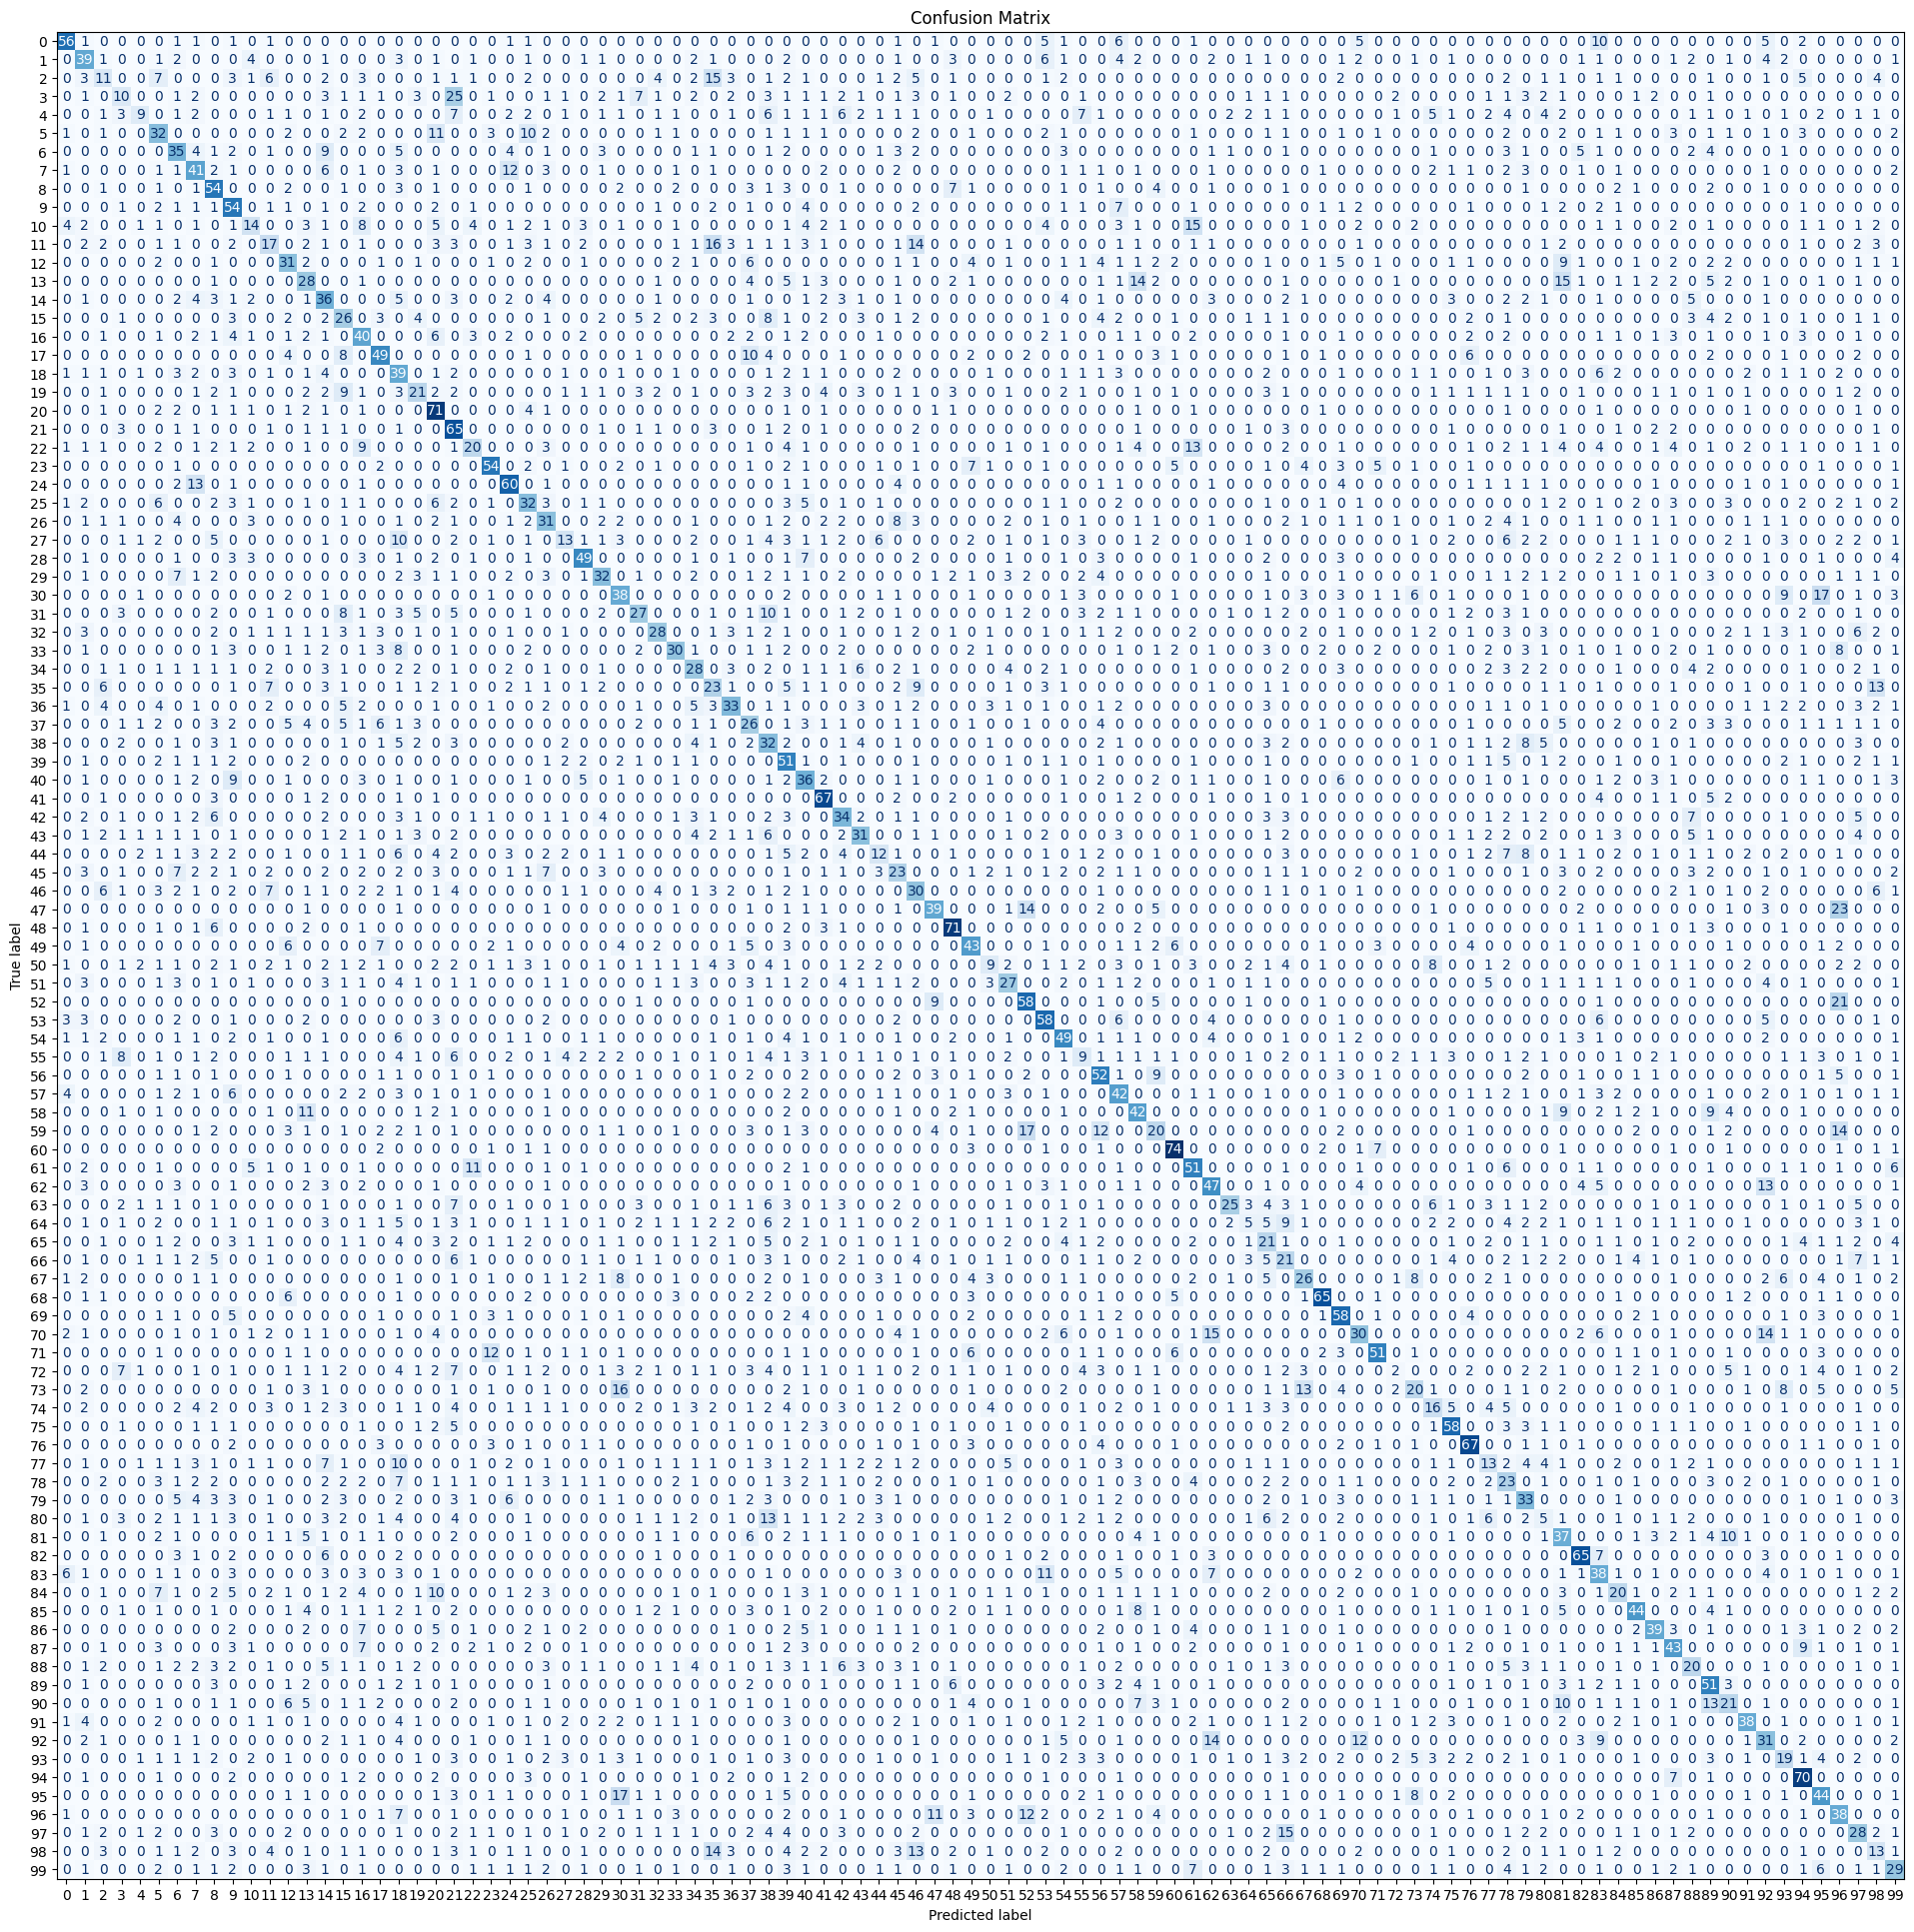

In [26]:
# Generate the confusion matrix
cm = test_light_ce_and_kd[0]

# Visualize the confusion matrix
fig, ax = plt.subplots()
fig.set_size_inches(24, 24)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
plt.title("Confusion Matrix")
plt.show()